### Piezo regulates epithelial packing through regulation in cell level processes such as adhesion, tension, proliferation and apoptosis (Manuscript in submission)

- Date - 11-12-2022
- Author - Nilay Kumar
- Designation - Graduate Student
- Department - Chemical and Biomolecular Engineering
- Lab - Multicellular system engineering Lab (Zartman Lab)
- School - University of Notre Dame

__Notebook Summary:__ 

The energy of the growing _Drosophila_ wing imaginal disc (epithelial tissue) is modeled according to the method described by Farhadifar et al$^{[1]}$ using Tyssue$^{[2]}$. This model incorporates surface tension, area elasticity, and perimeter-based contractility functions. The growth of the tissue is also modeled according to Farhadifar et al, where cells within the tissue are assigned growth rates with added noise. The growth is further patterned, with higher growth rates at the center and lower growth rates at the boundaries. The assumption of patterned growth is based on research conducted by Mao et al$^{[3]}$, which shows that growth decreases as one moves away from the center of the tissue. When cells reach a critical volume, they are split using Tyssue's inbuilt cell division module. Apoptosis within the epithelia has been modified to add to the effect of contraction on neighboring cells inspired by Monier et al$^{[4]}$. Cells with an area less than a specified value are permitted to shrink. During this process, the neighboring cells are also pulled and contracted using a defined radial tension through the use of Tyssue's inbuilt module. Upon reaching a critical area, cells are eliminated based on the number of neighboring cells. If the number of neighboring cells is three or less, the cell is removed from the epithelium. If the number of neighboring cells is greater than three, a rearrangement occurs along the shortest side. Additionally, rearrangements can also occur based on edge lengths. If the length of a particular edge of a cell is less than a specified threshold value, a rearrangement takes place along the shortest side.

__References:__

1. Farhadifar R, Röper JC, Aigouy B, Eaton S, Jülicher F. The influence of cell mechanics, cell-cell interactions, and proliferation on epithelial packing. Current Biology. 2007 Dec 18;17(24):2095-104.
2. Theis S, Suzanne M, Gay G. Tyssue: an epithelium simulation library. Journal of Open Source Software. 2021 Jun 7;6(62):2973.
3. Mao Y, Tournier AL, Hoppe A, Kester L, Thompson BJ, Tapon N. Differential proliferation rates generate patterns of mechanical tension that orient tissue growth. The EMBO journal. 2013 Oct 30;32(21):2790-803.
4. Monier B, Gettings M, Gay G, Mangeat T, Schott S, Guarner A, Suzanne M. Apico-basal forces exerted by apoptotic cells drive epithelium folding. Nature. 2015 Feb;518(7538):245-8.

In [1]:
# Importing libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython import display
import ipyvolume as ipv
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 0. User specified model parameter values

In [2]:
"""
I. Parameters for defining the energy of epithelia
"""
# Parameter for defining the edge tension of the cell
param_line_tension = 0.06
# Parameter for defining the face elasticity of the cell
param_area_elasticity = 1.0 
# The parameter for defining the perimeter contractility within cell
param_contractility = 0.04
# The resting area of cell
param_prefered_area = 1.0

"""
II. Parameters for modeling growth
"""
# maximum growth rate of cells (assigned to cell closest to the center of pouch)
rate_max = 0.04
# minimum growth rate of cells (assigned to the cell fartgest from the pouch)
rate_min = 0.00002
# Area at which a cell divides into two daughter cells
critical_division_area = 1.1

"""
III. Parameters for modeling contraction and apoptosis
"""
# Area below which cell starts to shrink instead of growing preparing for elimination
param_thres_apoptosis_area = 0.5
# Area at which the cell is ready for elimination
param_critical_apoptosis_area = 0.5
# Edge length below which a T1 transition can occur
critical_edge_length = 0.05
# Rate at which the cell shrinks during the contraction process
param_decrease_rate = 1.05
# Radialtension added to cells furing the contraction process.
param_radial_tension = 0.005
# Fraction by which neighboring cells shrink/expand during contaction
param_contractile_increase= 0.95


"""
IV. Other model parameters
"""
# Total simulation time/iterations
stop = 120
# Time step after which simulation statistics are printed
t_print_time = 10
# Maximum number of cells in thepithelia
num_max_cells = 4000
# Cells after which the crictical area and thresh area of apoptosis are changed from the default values
num_perturbation_cells = 500

"""
V. Saving files details
"""
current_directory_code = 'C:/Users/Nilay/Desktop/Piezo_simulations/'
new_dir_name = 'samplecaseStudy'

## 1. Initializing the geometry and defining the energy

- 1.1 The portion of code first creates a 2D sheet. 
- 1.2 We next define the energies
- 1.3 Use the quasistatic solver to obtain and visualize the minimum energy configuration 

C++ extension are not available for this version
collision solver could not be imported You may need to install CGAL and re-install tyssue


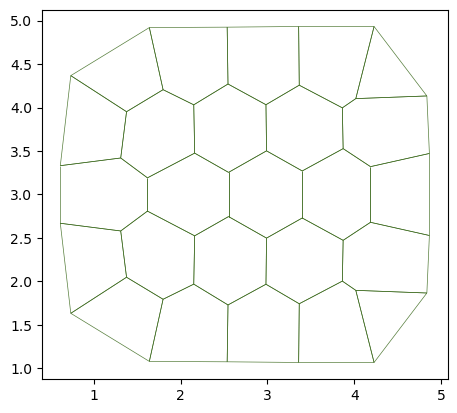

In [3]:
"""
The initial geometry and model energy description has been taken from Tyssue's
tutorial website:https://tyssue.readthedocs.io/en/latest/notebooks/04-Solvers.html
"""

"""
1.1 The portion of code first creates a 2D sheet.
"""

# Importing libraries of defining initial 2D epithelial sheet geometry 
# Core object
from tyssue import Sheet
# Simple 2D geometry
from tyssue import PlanarGeometry as sgeom
# Visualisation
from tyssue.draw import (
    sheet_view,
    highlight_faces,
    create_gif,
    browse_history
)

# Defining the properties of initial geometry
sheet = Sheet.planar_sheet_2d(
    'basic2D', # a name or identifier for this sheet
    nx=6, # approximate number of cells on the x axis
    ny=7, # approximate number of cells along the y axis
    distx=1, # distance between 2 cells along x
    disty=1, # distance between 2 cells along y
    noise=0 # some position noise
)

# Updating the sheet properties
sgeom.update_all(sheet)

# Give the tissue a nice hear cut ;)
sheet.sanitize(trim_borders=True, order_edges=True)
sgeom.update_all(sheet)

"""
1.2 We next define the energies
    a. Tension - Edge (length attribute)
    b. Elasticity - Face (area attribute)
    c. Contractility - face (perimeter attribute)
"""
# Loading the planar vertex model from Tyssue as smodel
from tyssue.dynamics.planar_vertex_model import PlanarModel as smodel
# Importing quas-static solver from Tyssue solvers
from tyssue.solvers import QSSolver
# Pretties visualizing data structuress
from pprint import pprint

# Defining the parameters for energies
specs = {
    'edge': {
        'is_active': 1, # Is the edge active within a simulation
        'line_tension': param_line_tension, # Defining the tension of the edge
        'ux': 0.0,
        'uy': 0.0,
        'uz': 0.0
    },
   'face': {
       'area_elasticity': param_area_elasticity, # Defining the face elasticity of the cell
       'contractility': param_contractility, # Defining the perimeter contractility within cell
       'is_alive': 1, # Check if the cell is present within the simulation step
       'prefered_area': param_prefered_area}, # The resting area of cell
   'settings': {
       'grad_norm_factor': 1.0, 
       'nrj_norm_factor': 1.0
   },
   'vert': {
       'is_active': 1
   }
}

# Update the specs (adds / changes the values in the dataframes' columns)
sheet.update_specs(specs)

"""
1.3 Use the quasistatic solver to obtain and visualize the 
    minimum energy configuration 
"""
# Defining specification for scipy.optimize.minimize gradient descent
min_settings = {
        'options': {
            'disp': False,
            'ftol': 1e-5,
            'gtol': 1e-4},
}

# Calling the quasistatic solver
solver = QSSolver()

# Solving the geomwwtry for computing minimum energy configuration
res = solver.find_energy_min(sheet, sgeom, smodel, **min_settings)

# Visualizing the minimum energy configuration
fig, ax = sheet_view(sheet, mode="2D")

## 2. Initialzing the eventmanager.

- The eventmanage within Tyssue is used to manage contraction event within epithelia.to manage contraction of cells within the epithelia

In [4]:
# Importing eventmanager from tyssue
from tyssue.behaviors import EventManager

# Initialisation of manager 
manager = EventManager("face")

# Defining cell ids and adding radial tension column to the face dataframe.
# The radial_tension column is necessary for adding radial tension to cells while contraction event. 
sheet.vert_df['radial_tension'] = np.zeros((len(sheet.vert_df),1))
sheet.face_df['id'] = sheet.face_df.index.values

## 3. Simulating dynamics of the growing epithelia. 

Each iteration of the main part consists of several steps The processes are assumed to be quasistatic.
- 3.1 Cells whose area is less than a particular user defined threshold_apoptosis_area but greater than critical_apoptosis_area are contracted. During this process the neighbors are also pulled under the action of radial tension.
- 3.3 Based on the distance of the cell from the center of pouch a growth rate is assigned in such a way that it decreases as one moves away from the pouch.
- 3.3 Cells whose area is greater than thres_apoptosis_area but less than critical_divsion_area are allowed to grow with the calculated growth rate and cells with area greater than critical divison area rae split into two daughter nuclei. 
- 3.4 Cells with area less than critical apoptosis area undergo rearrangements or elimination based on number of sides/
- 3.5 The shet after these processes is stored in the history object for quantificatio and visualization


- 

In [5]:
"""
Calling in tyssue ibraries
"""
# Tracks changes made to the sheet
from tyssue import History
# Simulates Programmed cell death in the sheet
from tyssue.behaviors.sheet import apoptosis
# Simulates pulling of cells in the sheet
from tyssue.behaviors.sheet.actions import ab_pull
# Simulates the shrinking of cells
from tyssue.behaviors.sheet.actions import shrink
# Decrease the value in the dataset at position index/col
from tyssue.behaviors.sheet.actions import decrease
# Simulates the process of contraction of cells
from tyssue.behaviors.sheet.basic_events import contraction
# Simulates the exchange of cells  
from tyssue.behaviors.sheet.actions import exchange
# Removal of cells from the epithelial sheet
from tyssue.behaviors.sheet.actions import remove
# Calling the sheet as a planar geometry
from tyssue import PlanarGeometry
# Resolve topological changes (t1 transitions) in the epithelial sheet
from tyssue.topology.sheet_topology import resolve_t1s
from tyssue.topology.sheet_topology import type1_transition
from tyssue.topology.sheet_topology import cell_division
# Suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Measuring execution time of code
import time
start = time.process_time()


# Initializing the time counter
t = 0
# The initialvalue of parameters for selecting when a cell divides or dies
thres_apoptosis_area = 0.02
critical_apoptosis_area = 0.02

# The History object records all the time steps 
history = History(sheet)

# Starting the simulation. Runs for iterations defined by user or till the sheet reaches a number of cells defined by user
while t < stop and len(sheet.face_df) < num_max_cells:
    
    # Canging the parameter values for selecting cells that grow or shrink after the perturbation time defined by user
    if len(sheet.face_df) > num_perturbation_cells:
        thres_apoptosis_area = param_thres_apoptosis_area
        critical_apoptosis_area = param_critical_apoptosis_area
    
    # Preen sheet statistics after every t_print_time steps
    if t%t_print_time == 0:
        # Printing time elapse
        print("The time elapsed is "+ str(time.process_time() - start) + " seconds")
        # Printing the total number of cells
        print("The total number of cells in sheet after " + str(t) + " iterations is " + str(len(sheet.face_df)))
    
    """
    3.1 a) Loop throgh all the cell faces
        b) If: thres apoptosis_area < cell area < critical apoptosis area
            i) Cell contracts
            ii) Neighbors are pulled by addition of radial tension
            iii) Neighboring cells are contracted
        c) Geometry is updated and the sheet is reindexed
        d) Minimum energy configuration is determined
    """
    # Updating the id of cells in sheet
    sheet.face_df['id'] = sheet.face_df.index.values
    # Itearting through all the faces/cells in sheet
    for i in range(len(sheet.face_df)):
        # If the area of cell is less than threshold but greater than critical contraction happens
        if sheet.face_df.loc[i, "area"] > critical_apoptosis_area and sheet.face_df.loc[i, "area"] < thres_apoptosis_area:
            # Decreasing the area of chosen cells that is shrinking
            # decrease_rate: The cell area is divided (divide = True) by decrease rate to calculate new area
            # preffered area of cell is changed 
            decrease(sheet,"face", i, decrease_rate=param_decrease_rate, col = 'prefered_area', divide=True)
            # Adds radial_tension to the face’s vertices radial_tension
            ab_pull(sheet, i, radial_tension=param_radial_tension, distributed=False)
            # Acessing the list of neighbors for th eparticular cell
            neighbors = sheet.get_neighborhood(i, 1).dropna()
            neighbors["id"] = sheet.face_df.loc[neighbors.face, "id"].values
            # Adding the contraction of neighbors in the event manger
            manager.extend(
                [
                    (
                        contraction, # Initiating the contraction event for neighboring cells
                        {
                            "face_id": neighbor["id"],
                            # Th neighboring cell area is multiplied by contractile increase to model contraction of neighboring cells
                            "contractile_increase": (
                                param_contractile_increase / neighbor["order"],
                            ),
                        },
                    )
                    for _, neighbor in neighbors.iterrows()
                ]
            )
    # Execting the event manager for contraction of neighbors       
    manager.execute(sheet)
    # Resetting the cell ids
    sheet.reset_index(order=True)
    # Resetting the topology of sheet
    sheet.reset_topo()
    # Updating the geometry with the new geometry
    sgeom.update_all(sheet)
    # Determining the minimum energy coniguration of sheet
    res = solver.find_energy_min(sheet, sgeom, smodel)
    # Updating the manager
    manager.update()
    
    """
    3.2 a) Distance of the cells from center of pouch is calculated
        b) Cell with least distance is assigned the mximum growth rate (rate_max)
        c) Cells with the maxiumum distance from center is assigned a minimum growth rate
        d) For all other cells the growth rate is calculated using linear regression
    """
    # Initializing lists for storing the x and y coordinates of the cells
    x_cells = []
    y_cells = []
    # Initializing lists for storing area of cells
    area_cells = []
    # x_dis = (x_cell - x_center_tissue)^2
    x_dis = []
    # y_dis = (y_cell - y_center_tissue)^2
    y_dis = []
    # Initializing lists for storing distance of cells from center
    dis_cells = []
    # Initializing the array for storing growth rates of cells
    rate_proliferation_cells = []
    # Fetching x and y coordinates and cell area foem the face dataframe
    x_cells = sheet.face_df['x'].to_numpy()
    y_cells = sheet.face_df['y'].to_numpy()
    area_cells = sheet.face_df['area'].to_numpy()
    # Calculating the area weighted  center of mass of tissue
    # center of mass is defined as = sum(ai x Xi) / sum(ai)
    x_cm = np.sum(np.multiply(x_cells,area_cells))/np.sum(area_cells)
    y_cm = np.sum(np.multiply(y_cells,area_cells))/np.sum(area_cells)
    # Calculating distance of cells fromc center
    x_dis = np.square(x_cells-x_cm)
    y_dis = np.square(y_cells-y_cm)
    dis_cells = np.sqrt(x_dis+y_dis)
    # Interpolating growth rate as a function of distance using linear regression
    # Growth rate at minimum distance= rate_max
    # Growth rate maximum distance = rate_min 
    constant_multiplier_rate = (rate_min -rate_max)/np.max(dis_cells)
    rate_proliferation_cells = constant_multiplier_rate*dis_cells + rate_max
    
    """
    3.3 a) If:  thres_apoptosis_area < cell_area < critical_division_area => Cell grows with thee calculated growth rate
        b) If: cell area > critical_division_area => cell splits into two daughter cells
    """
    # Initializing xounter for number of cells which are dividing
    num_division = 0
    # Itearing over all the cells in the sheet
    for i in range(len(sheet.face_df)):
        # Choosing if the cell is ready to grow based on the area of cells as defined above
        if sheet.face_df.loc[i, "area"] > thres_apoptosis_area and sheet.face_df.loc[i, "area"] <critical_division_area:
            # The preffered area of cell is changed to simulate growth
            sheet.face_df.loc[i, "prefered_area"] *= (1 + rate_proliferation_cells[i])
        # Checking if the cell is ready to divide
        elif sheet.face_df.loc[i, "area"] > critical_division_area: 
            # Increasing the counter to count the totalnumber of dividing cells
            num_division = num_division + 1
    
    res = solver.find_energy_min(sheet, sgeom, smodel, **min_settings)
    sheet.sanitize(trim_borders=True)
    sheet.reset_index(order=True)
    sheet.reset_topo()
    sgeom.update_all(sheet)
    
    # Iterating over the number of cells that are ready to divide
    for p in range(num_division+1):
        # Itearting over all the cells
        for q in range(len(sheet.face_df)):
            # Identifying the cell ready for division
            if sheet.face_df.loc[q, "area"] > critical_division_area:
                # Setting the preferred area of the dividing cell as the set are
                sheet.face_df.loc[q, "prefered_area"] = param_prefered_area
                # Dividing the cell
                daughter = cell_division(sheet, q, sgeom)
                # updating the indices of cells in sheet
                sheet.reset_index(order=True)
                # updating the geometry
                sgeom.update_all(sheet)
                # Breaking out of the second loop to find th enext cell tha tis ready for division
                break
    # Determining the minimum energy coniguration of sheet            
    res = solver.find_energy_min(sheet, sgeom, smodel, **min_settings)
    # Updating the sheets
    sheet.reset_index(order=True)
    sgeom.update_all(sheet)
    
    """
    3.4 Simulating apoptosis and rearrangements 
        Case 1:area_Cell < crtical_apoptosis_area and number of sides > 3
            -> A T1 transition occurs along the shorter side of the cell
        Case 2:area_Cell > crtical_apoptosis_area and shortest side < xrirical_edge_length
            -> A T1 transition occurs along the shorter side of the cell
        Case 3:area_Cell < crtical_apoptosis_area and number of sides <= 3
            -> Cell is removed from the sheet
    """
    # Starting the counter to count the number of apoptotic cells
    num_apoptotic_runs = 1
    # Approximate the number of apoptotic events and rearrangements
    # Counting the cells with area less than critical_apoptosis area
    # For all other cells if the shortest side is less than critical_edge_length
    # Iterating over all the cells in sheet 
    for i in range(len(sheet.face_df)):
        # Findingg the edge lengths of all the edges in cells
        edges_cell_dummy = sheet.edge_df[sheet.edge_df["face"] == i]
        # Finding th elength of shortest cell
        shorter_side_dummy = edges_cell_dummy.length.min()
        # Check if area of cell is less than thres_apoptosis_area 
        # OR
        # If the shortest side of the cell is less than critical_edge_length
        if sheet.face_df.loc[i, "area"] < critical_apoptosis_area or shorter_side_dummy < critical_edge_length:
            # Increasing the counter of apoptotic cells
            num_apoptotic_runs = num_apoptotic_runs + 1 
     
    # Iterating over all the apoptotic cells
    # 10 is just added as an extra padding. No significance, can be any number
    for i in range(num_apoptotic_runs+10):
        # For each apoptosis run we iterate over all the cells in sheet
        for j in range (len(sheet.face_df)):
            # Calculating the shortest side of the cell
            edges_cell = sheet.edge_df[sheet.edge_df["face"] == j]
            shorter_side = edges_cell.length.min()
            # Case 1: area_Cell < crtical_apoptosis_area and number of sides > 3
            if sheet.face_df.loc[j, "area"] < critical_apoptosis_area and sheet.face_df.loc[j, "num_sides"] > 3:
                # A T1 transition occurs along the shortest side of the cell
                exchange(sheet, j, geom = sgeom)
                # Resetting the cell index and topology of sheet
                sheet.reset_index(order=True)
                sheet.reset_topo()
                # Breaking from the loop and moving to the next apoptotic run
                break
            # Case 2: area_Cell > crtical_apoptosis_area and shortest side < xrirical_edge_length
            elif sheet.face_df.loc[j, "area"] > critical_apoptosis_area and shorter_side < critical_edge_length:
                # A T1 transition occurs along the shortest side of the cell
                exchange(sheet, j, geom = sgeom)
                # Resetting the cell index and topology of sheet
                sheet.reset_index(order=True)
                sheet.reset_topo()
                # Breaking from the loop and moving to the next apoptotic run
                break
            # Case 3: area_Cell < crtical_apoptosis_area and number of sides <= 3
            elif sheet.face_df.loc[j, "area"] < critical_apoptosis_area and sheet.face_df.loc[j, "num_sides"] <= 3:
                # Removing the cell from the sheet
                remove(sheet, j, geom = sgeom)
                # Resetting the cell index and topology of sheet
                sheet.reset_index(order=True)
                sheet.reset_topo()
                # Breaking from the loop and moving to the next apoptotic run
                break
                
    # Determining the minimum energy coniguration of sheet
    res = solver.find_energy_min(sheet, sgeom, smodel, **min_settings)
    # Trimming cells with unwanted topological defects at boundary
    sheet.sanitize(trim_borders=True)
    # Resetting the sheet index and tissue geometry
    sheet.reset_index(order=True)
    sheet.reset_topo()
    # Updating the geometry
    sgeom.update_all(sheet)
    
    """
    3.5 Recording data in the history 
    """
    # Updating the time counter
    t += 1    
    # Resetting the cell index and the topology of sheet
    sheet.reset_index(order=True)
    sheet.reset_topo()
    sgeom.update_all(sheet)
    # Recording the current data in history object
    history.record()
    
# Printing the final status of simulation
print("Simulation complete")

The time elapsed is 0.015600099999998562 seconds
The total number of cells in sheet after 0 iterations is 25
The time elapsed is 23.431350200000004 seconds
The total number of cells in sheet after 10 iterations is 25
The time elapsed is 54.101146799999995 seconds
The total number of cells in sheet after 20 iterations is 31
The time elapsed is 82.68053 seconds
The total number of cells in sheet after 30 iterations is 38
The time elapsed is 112.632722 seconds
The total number of cells in sheet after 40 iterations is 46
The time elapsed is 149.3241572 seconds
The total number of cells in sheet after 50 iterations is 61
The time elapsed is 181.1795614 seconds
The total number of cells in sheet after 60 iterations is 76
The time elapsed is 226.6538529 seconds
The total number of cells in sheet after 70 iterations is 98
The time elapsed is 289.6002564 seconds
The total number of cells in sheet after 80 iterations is 128
The time elapsed is 348.1318316 seconds
The total number of cells in she

## 4. Data Visualization and storing
- 4.1 Epithelia colorcoded by number of sides and area of cells
- 4.2 Final distribution of area of cells and distribution of neighborhood frequency
- 4.3 Saving the topology of epithelia after every iteration
- 4.4 Evolution of distribution of neighborhood of cells with nu,ber of cells (convergence).Saving datafile generated during simulatio as numpy arrays. 

'\nfig, ax = sheet_view(sheet, coords, **draw_specs)\nfig.set_size_inches((8, 4))\n'

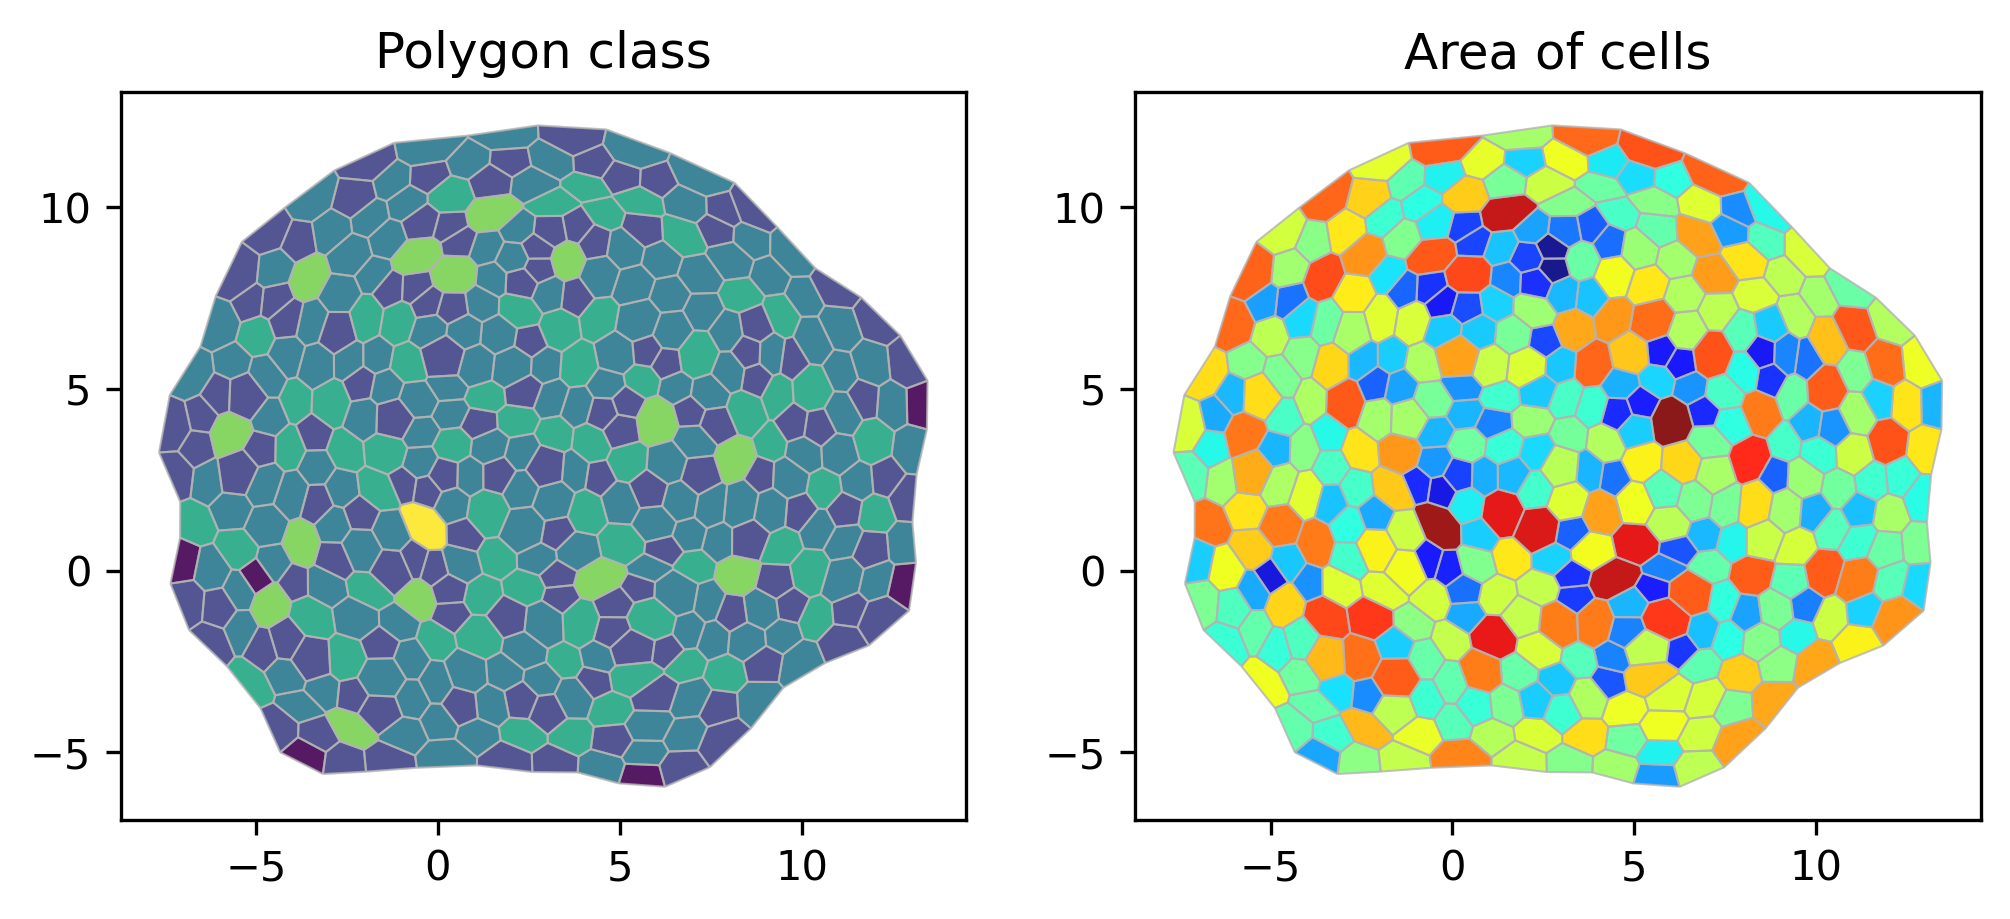

In [17]:
"""
4.1 Epithelia colorcoded by number of sides and area of cells
"""
# Importing tyssue
import tyssue
# importing sheet geometry as geom
from tyssue import Sheet, SheetGeometry  as geom
# Importing drawing modules of tyssue
from tyssue.draw import sheet_view
#
from tyssue import config

# Calling in the specifications for drawing the sheet
draw_specs = tyssue.config.draw.sheet_spec()
# coordinates of the cells
coords = ['x', 'y']

# fetching x coordinates of all the cells in sheet
x_cells_final_sheet = sheet.face_df['x'].to_numpy()
# fetching y coordinates of all the cells in sheet
y_cells_final_sheet = sheet.face_df['y'].to_numpy()
# calculating the rabge along x axis (minimum and maximum values)
x_max_sheet = np.max(x_cells_final_sheet)
x_min_sheet = np.min(x_cells_final_sheet)
# calculating the rabge along y axis (minimum and maximum values)
y_max_sheet = np.max(y_cells_final_sheet)
y_min_sheet = np.min(y_cells_final_sheet)

# Defining the colormap for plotting number of sides
color_value = sheet.face_df['num_sides'].to_numpy()
# color_value[color_value != 6] = 1 # Use only if you want to highlight only 6 sided cells

# Defining an additional value of color in the face dataframe of sheet
sheet.face_df['color'] = color_value
# sheet.face_df['color'] = sheet.face_df['num_sides'] 
draw_specs['edge']['visible'] = True # The edges in the sheet sare visible
draw_specs['edge']['color'] = sheet.edge_df['line_tension'] # Edges colorcodes bt line tension # Note: Constant in model
draw_specs['face']['visible'] = True # Show the faces of the sheet
draw_specs['face']['color'] = sheet.face_df['color'] # Colorcode the sheet based on the number of neighbors
draw_specs['face']['alpha'] = 0.9 # Define transparancey of fave coloring

# Defining figure properties
fig, axs = plt.subplots(nrows = 1,ncols = 2,figsize= (8, 4), dpi=300)
# Plotting the sheet where cells are colorcoded by nuber of sides
fig1 = sheet_view(sheet, coords, **draw_specs, ax = axs[0])

# Defining the colormap for plotting area
# Linearly normalizes data into the [0.0, 1.0] interval.
norm = plt.Normalize()
# Defining the xolormap based on normalized cell area
colors = plt.cm.jet(norm(sheet.face_df['area']))
draw_specs['face']['color'] = colors # Replacing the color array with colors used for plotting cell area
# Plotting the sheet where cells are colorcoded by cell area
fig2 = sheet_view(sheet, coords, **draw_specs, ax = axs[1])
# Setting th eplot titles
axs[0].title.set_text('Polygon class')
axs[1].title.set_text('Area of cells')

"""
fig, ax = sheet_view(sheet, coords, **draw_specs)
fig.set_size_inches((8, 4))
"""

In [19]:
print(y_max_sheet)

11.87525752617527


__Figure 1: Epithelium visualization:__ *(A)The cells are colorcoded based on number of sides. (B) The cells are colorcoded based on area* 

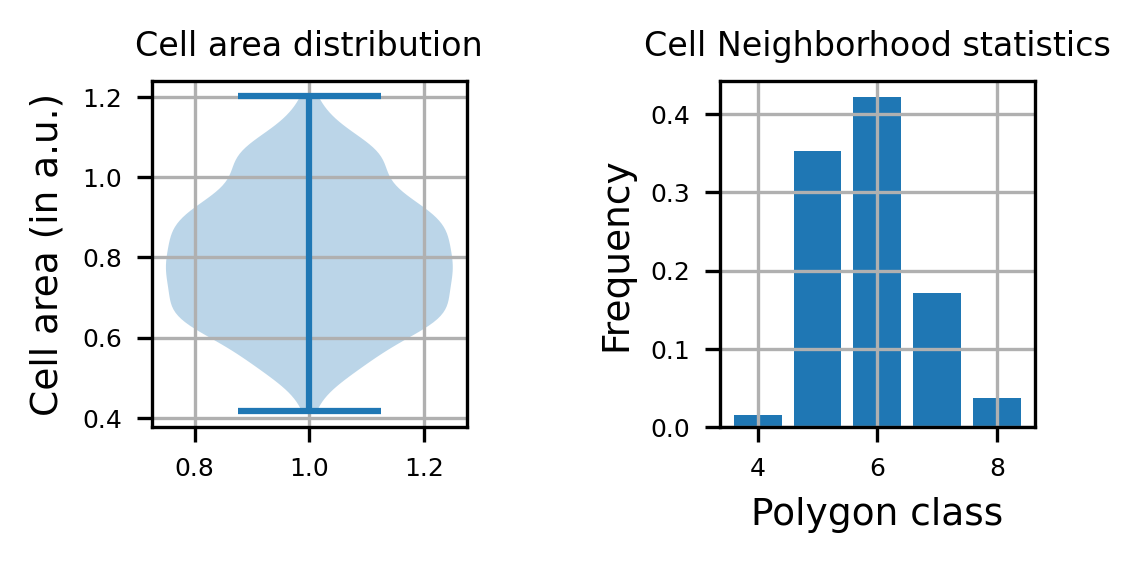

In [20]:
"""
4.2 Final distribution of area of cells and distribution of neighborhood frequency
"""
# Part 1: Data preparation 

# Fetching the area of cells from the sheet
area_cells_sheet = sheet.face_df['area'].to_numpy()
# Fetching the num of faces of cells from the sheet
neighbors_cells_sheet = sheet.face_df['num_sides'].to_numpy()
# Setting the data to plot area as data_to_plot
data_to_plot = [area_cells_sheet]
# Initializing the array to store the frequency of cells with sides varying from 4 to 8
frequency_polygon = np.zeros((5,))
polygon_nature = [4, 5, 6, 7, 8]
# Iterating over the number of faces for which the frequency in epithelia is to be evaluated
for i in range(len(polygon_nature)):
    # Counting the nu,ber of cels with the particular number of faces
    frequency_polygon[i] = np.count_nonzero(neighbors_cells_sheet == polygon_nature[i])
# Dividing the count with totalnumber of cells to obtain a frequency or distribution of number of faces
frequency_polygon = frequency_polygon/len(sheet.face_df)

# Part 2: Plotting

# Defining the properties of figure
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(3.8, 1.5), dpi=300)

# Plotting the distribution of cell srea as a violinplot
# Calling in the axes of the first subplot
ax1 = plt.subplot(121)
# Calling the violinplot for plotting distribution of cell area 
ax1.grid()
ax1.violinplot(data_to_plot)
#ax1.set_xlim([0,2])
# Setting the labl of the y axis
ax1.set_ylabel('Cell area (in a.u.)', fontsize=9)
ax1.tick_params(axis='both', which='major', labelsize=6)
# Setting the title of th eplot
ax1.set_title('Cell area distribution', fontsize = 8)

# Calling in the axes of the second subplot
ax2 = plt.subplot(122)
# Plotting the distribution of number of sides as a bar plot
ax2.grid()
ax2.bar(polygon_nature, frequency_polygon)
#ax2.set_xlim([4,8])
# Setting the ylabel of plot
ax2.set_ylabel('Frequency', fontsize=9)
ax2.tick_params(axis='both', which='major', labelsize=6)
# Setting the x axis label for plot
ax2.set_xlabel('Polygon class', fontsize=9)
# Setting the title of plot
ax2.set_title('Cell Neighborhood statistics', fontsize = 8)
plt.subplots_adjust(hspace=30)
plt.subplots_adjust(wspace=.8)


__Figure 2: Visualizing sheet statistics__*(A) Violin plot showing the distribution of cell area in the sheet. (B) Bar graph showing the distribution of frequency of polyygon class in the sheet* 

In [22]:
"""
4.3 Saving the topology of epithelia after every iteration
"""
# Importing pathlib for creating new folder
import pathlib
# Creating new directory in the working folder based on user input
new_dir = pathlib.Path(current_directory_code, new_dir_name)
new_dir.mkdir(parents=True, exist_ok=True)

#Starting the counter
k = 0
# Calculating the number of time stamps in history. Starting the counter
t_end = 0
# Itearting over the history object
for t, sheet in history:
    # Color cells based on area
    #sheet.face_df['color'] = sheet.face_df['area']
    # Make the dges visible
    draw_specs['edge']['visible'] = True
    # Colorcode the edge based on line tension (Note: Foxed in our case)
    draw_specs['edge']['color'] = sheet.edge_df['line_tension']
    # Make faces visible
    draw_specs['face']['visible'] = True
    # Colorcode faces based on number of sides
    draw_specs['face']['color'] = sheet.face_df['num_sides']
    # Define transparency
    draw_specs['face']['alpha'] = 0.9
    # Plotting the figure
    fig, ax = sheet_view(sheet, coords, **draw_specs)
    # Define the limit of s and axis. Set to fit the final tissue size
    ax.set(xlim=[x_min_sheet-5, x_max_sheet+5], ylim=[y_min_sheet-5, y_max_sheet+5])
    # Defining the directory and printing filename as the time stamp
    filename = current_directory_code + new_dir_name + "/" + str(t) + ".png"
    fig.savefig(filename)
    # Closing fifure
    plt.close(fig)
    # Increasing the time stamp counter
    t_end = t_end + 1

# Printing the status of task
print("Saving files complete")

Saving files complete


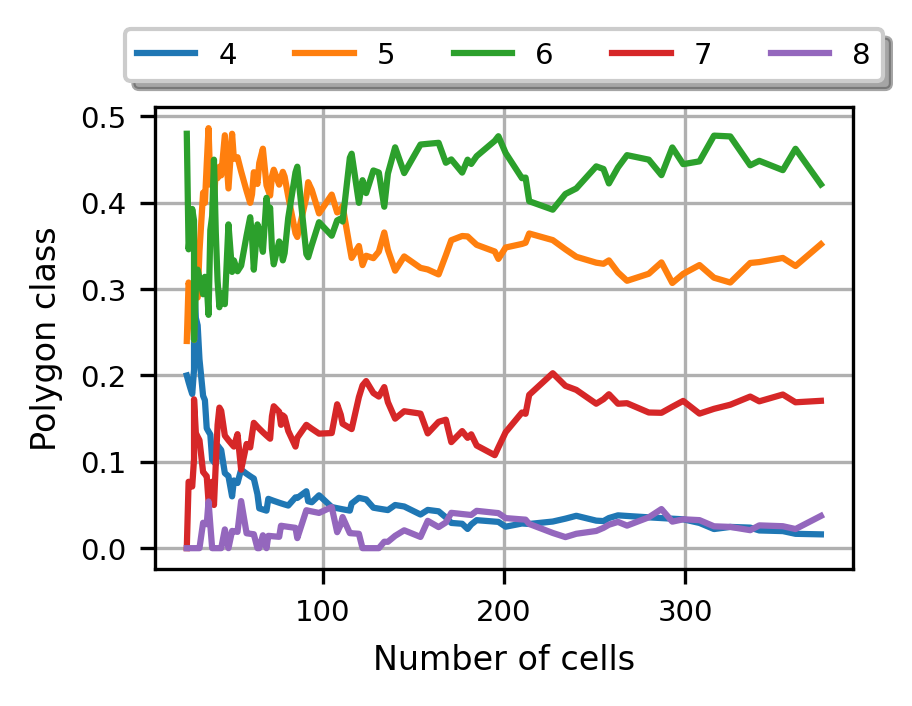

In [43]:
"""
4.4 Evolution of distribution of neighborhood of cells with number of cells (convergence).
    Saving datafile generated during simulatio as numpy arrays.
"""

k = 0
# This array will be used to store the frequency of cells with different
# numbers of sides for each time step.
frequency_polygon_time = np.zeros((t_end,5))
# Initializing the array  to store the mean area of cells in sheet over time
area_mean_time = np.zeros((t_end,))
# Initializing the array  to store the standard devisation of area of cells over time
area_std_time = np.zeros((t_end,))
# Initializing the array to store the number of cells in sheet with time
n_cells_time = np.zeros((t_end))

polygon_nature = [4, 5, 6, 7, 8]

# iterating through each time step of the simulation
for t, sheet in history:
    # Creating a temporary list to stor ethe cell areas
    area_temp = []
    # Extracting area of cells from the dataframe as a numpy array
    area_temp = sheet.face_df['area'].to_numpy()
    # Calculating the mean area of cells for the particular iteration
    area_mean_time[k] = np.mean(area_temp)
    # Calculating the standard deviation in area of cells for the particular iteration
    area_std_time[k] = np.std(area_temp)
    # Going through the faces whose numbers needs to be counted 
    for i in range(len(polygon_nature)):
        # Initializing the array that stores the number of faces each cells have
        neighbors_cells_sheet = []
        # Fetching the number of faces data from sheet object
        neighbors_cells_sheet = sheet.face_df['num_sides'].to_numpy()
        # Counting the number of cells equaling the number of faaces called within the loop 
        frequency_polygon_time[k,i] = np.count_nonzero(neighbors_cells_sheet == polygon_nature[i])
    
    #
    frequency_polygon_time[k,:] = frequency_polygon_time[k,:] / len(sheet.face_df)
    # Storing the number of cells in sheet in particular time
    n_cells_time[k] = len(sheet.face_df)
    # Increasing the counter
    k = k + 1
    
# Plotting the evolution of frequency of polygon class with number of cells in system
# Iterating over the polygon class elements whose frequency in the sheet over time has to be plotted
plt.figure(figsize=(3,2), dpi = 300)
for i in range(5):
    # Plotting the variation of frequency for the particular polygon class with the number of cells in sheet
    plt.plot(n_cells_time,frequency_polygon_time[:,i])

# Labelling the x axis
plt.xlabel("Number of cells", fontsize = 8)
# Labeling the y axis
plt.ylabel("Polygon class", fontsize = 8)
# Changing the font size of ticslabels
plt.tick_params(axis='both', which='major', labelsize=7)
# Labeling the legends, decifing the offset and attributes of legend
plt.legend(['4', '5', '6','7','8'], fontsize = 7, loc='upper center',
           ncol=5, fancybox=True, shadow=True, bbox_to_anchor=(0.5,1.2))
# Turning on plotting the grid within the figure
plt.grid()

# Saving data as numpy array for further analysis
np.save('frequency_polygon_time.npy', frequency_polygon_time)
np.save('n_cells_time.npy', n_cells_time)
np.save('area_mean_time.npy', area_mean_time)
np.save('area_std_time.npy', area_std_time)         